# Training Convergence Plots for Learning Punctuation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
import pickle
import os
print(os.getcwd())
import time
import gc
import torch
import bisect

from conv_plots_funcs import train_conv_plots

#import empirical cdf
# import sys
# sys.path.append(os.path.abspath('../../src'))

from data_processing import gen_ckpt_steps, move_dict_to_device, get_other_err, get_mop_ratios_ckpt, compute_ratio
# sys.path.append(os.path.abspath('..'))

from check_ecdf import get_empirical_cdf

/home/sultand/TFs_do_KF_ICL/src
/home/sultand/TFs_do_KF_ICL/src
/home/sultand/TFs_do_KF_ICL/src
Using device: cuda
Using device: cuda


In [2]:
valA = "gaussA"
valC = "_gauss_C"
state_dim = 10
ckpt_step = 8
batch_size = 2048 #512 #4096
gpus=1
num_val_sys = 25
experiment = "250125_092007.f34194_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000" # experiment to load
datasource = "val"
nope = True


compute_more_ckpts = False

/home/sultand/TFs_do_KF_ICL/outputs/train_conv/training_dist_comparison_val_gaussA_state_dim_10_val_sys_25_1737962177.9717734.pdf
quantiles 5 path exists?: True
ckpt_steps: [4000, 8000, 12000, 16000, 20000, 24000, 28000, 32000, 36000, 40000, 44000, 48000, 52000, 56000, 60000, 64000, 68000, 72000, 76000, 80000, 84000]
quantiles already exist for 250125_092007.f34194_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000, and single_system=True
keys in the file: ['pred_ckpts', 'quantiles']
quantiles shape after load: (21, 3)
loading quantiles_5 and quantiles_20
quantiles shape (21, 3)
no title for single system


(array([0.6545807, 2.468369 , 6.429947 ], dtype=float32),
 [8192000,
  16384000,
  24576000,
  32768000,
  40960000,
  49152000,
  57344000,
  65536000,
  73728000,
  81920000,
  90112000,
  98304000,
  106496000,
  114688000,
  122880000,
  131072000,
  139264000,
  147456000,
  155648000,
  163840000,
  172032000])

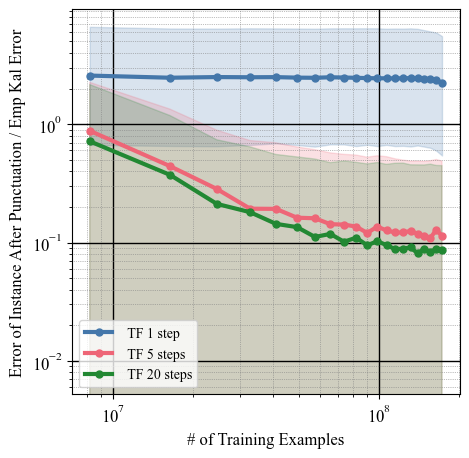

In [3]:
kal_ckpt = 60000 #81000 #28500
train_conv_plots([experiment], ["Identity"], [kal_ckpt], valA, valC, num_val_sys, compute_more_ckpts, None, 4000, 84000, 4000, state_dim, single_system=True, nope=nope, batch_size=batch_size, gpus=gpus)